In [24]:
import numpy as np
import pandas as pd
import polars as pl
import os
import matplotlib.pyplot as plt
import scipy.stats as st
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Data Preprocessing

This data contains EEG correlates of genetic predisposition to alcoholism.

In [2]:
file_names_full = os.listdir('C:/Users/bbari/Documents/EEG Analysis/eeg_full')
file_names_a=[]
file_names_c=[]
for filename in file_names_full:
    if filename.startswith('co2a') or filename.startswith('co3a'):
        file_names_a.append(filename)
    else:
        file_names_c.append(filename)
print(f'This data set contains {len(file_names_a)} alcholic and {len(file_names_c)} control subjects.')

This data set contains 77 alcholic and 45 control subjects.


**Alcholic(a) Subjects**<br>
Extract and merge alcholic(a) subjects. Converting parquet format after that.

In [ ]:
file_names_list=[]
for file in file_names_a:
    file_names_temp=os.listdir('C:/Users/bbari/Documents/EEG Analysis/eeg_full/' + file)
    file_names_temp=[f for f in file_names_temp if not f.endswith('.gz')]
    file_names_list.append(file_names_temp)
file_names_list

In [ ]:
output_parquet_file = "C:/Users/bbari/Documents/EEG Analysis/eeg_group_a.parquet"
for a in range(0,len(file_names_a)):
    for i in range(0,len(file_names_list[a])):               
        filename='C:/Users/bbari/Documents/EEG Analysis/eeg_full'+'/'+str(file_names_a[a])+ '/'+str(file_names_list[a][i])
        match_condition=pl.read_csv(filename,skip_rows=3,separator=',').columns[0][2:].strip() 
        my_data=pl.read_csv(filename,skip_rows=4,separator=" ",ignore_errors=True)
        my_data=my_data.with_columns(subject_group = pl.lit('a'),subject=pl.lit(str(file_names_a[a])),matching_condition=pl.lit(match_condition))
        if file_names_list[a][i]=='co2a0000364.rd.000':
            result=my_data
        else:
            result.extend(my_data)
    print(filename)
result=result.rename({"#": "trial_num","FP1": "sensor_position","chan": "sample_num(timestamp)","0": "sensor_value(voltage(mV))"})
result.write_parquet(output_parquet_file)

In [7]:
df_a = pd.read_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_group_a.parquet') 
df_a #115_671_751 rows

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,-8.921,a,co2a0000364,S1 obj
1,0.0,FP1,1.0,-8.433,a,co2a0000364,S1 obj
2,0.0,FP1,2.0,-2.574,a,co2a0000364,S1 obj
3,0.0,FP1,3.0,5.239,a,co2a0000364,S1 obj
4,0.0,FP1,4.0,11.587,a,co2a0000364,S1 obj
...,...,...,...,...,...,...,...
115671746,119.0,Y,251.0,38.656,a,co3a0000461,S2 match
115671747,119.0,Y,252.0,37.679,a,co3a0000461,S2 match
115671748,119.0,Y,253.0,37.191,a,co3a0000461,S2 match
115671749,119.0,Y,254.0,37.679,a,co3a0000461,S2 match


**Control(c) Subjects**<br>
Extract and merge control(c) subjects. Converting parquet format after that.

In [ ]:
file_names_list_2=[]
for file in file_names_c:
    file_names_temp=os.listdir('C:/Users/bbari/Documents/EEG Analysis/eeg_full/' + file)
    file_names_temp=[f for f in file_names_temp if not f.endswith('.gz')]
    file_names_list_2.append(file_names_temp)
file_names_list_2

In [ ]:
output_parquet_file = "C:/Users/bbari/Documents/EEG Analysis/eeg_group_c.parquet"
for a in range(0,len(file_names_c)):
    for i in range(0,len(file_names_list_2[a])):
        filename='C:/Users/bbari/Documents/EEG Analysis/eeg_full'+'/'+str(file_names_c[a])+ '/'+str(file_names_list_2[a][i])
        match_condition=pl.read_csv(filename,skip_rows=3,separator=',').columns[0][2:].strip() 
        my_data=pl.read_csv(filename,skip_rows=4,separator=" ",ignore_errors=True)
        my_data=my_data.with_columns(subject_group = pl.lit('c'),subject=pl.lit(str(file_names_c[a])),matching_condition=pl.lit(match_condition))
        if file_names_list_2[a][i]=='co2c0000337.rd.000':
            result=my_data
        else:
            result.extend(my_data)
    print(filename)
result=result.rename({"#": "trial_num","FP1": "sensor_position","chan": "sample_num(timestamp)","0": "sensor_value(voltage(mV))"})
result.write_parquet(output_parquet_file)

In [9]:
df_c = pd.read_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_group_c.parquet') 
df_c #66_182_728 rows

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,3.082,c,co2c0000337,S1 obj
1,0.0,FP1,1.0,2.594,c,co2c0000337,S1 obj
2,0.0,FP1,2.0,2.106,c,co2c0000337,S1 obj
3,0.0,FP1,3.0,2.106,c,co2c0000337,S1 obj
4,0.0,FP1,4.0,3.571,c,co2c0000337,S1 obj
...,...,...,...,...,...,...,...
66182723,119.0,Y,251.0,-37.292,c,co3c0000402,S2 match
66182724,119.0,Y,252.0,-36.316,c,co3c0000402,S2 match
66182725,119.0,Y,253.0,-34.363,c,co3c0000402,S2 match
66182726,119.0,Y,254.0,-33.386,c,co3c0000402,S2 match


**Merge Two Subject Groups in One DataFrame**

In [10]:
df_merged=pd.concat([df_a,df_c])
df_merged #181_854_479 rows

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,-8.921,a,co2a0000364,S1 obj
1,0.0,FP1,1.0,-8.433,a,co2a0000364,S1 obj
2,0.0,FP1,2.0,-2.574,a,co2a0000364,S1 obj
3,0.0,FP1,3.0,5.239,a,co2a0000364,S1 obj
4,0.0,FP1,4.0,11.587,a,co2a0000364,S1 obj
...,...,...,...,...,...,...,...
66182723,119.0,Y,251.0,-37.292,c,co3c0000402,S2 match
66182724,119.0,Y,252.0,-36.316,c,co3c0000402,S2 match
66182725,119.0,Y,253.0,-34.363,c,co3c0000402,S2 match
66182726,119.0,Y,254.0,-33.386,c,co3c0000402,S2 match


In [11]:
df_merged.to_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged.parquet.gzip',compression='gzip',index=False)

In [2]:
df_merged = pd.read_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged.parquet.gzip')
df_merged #181_157_888 rows

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,-8.921,a,co2a0000364,S1 obj
1,0.0,FP1,1.0,-8.433,a,co2a0000364,S1 obj
2,0.0,FP1,2.0,-2.574,a,co2a0000364,S1 obj
3,0.0,FP1,3.0,5.239,a,co2a0000364,S1 obj
4,0.0,FP1,4.0,11.587,a,co2a0000364,S1 obj
...,...,...,...,...,...,...,...
181854474,119.0,Y,251.0,-37.292,c,co3c0000402,S2 match
181854475,119.0,Y,252.0,-36.316,c,co3c0000402,S2 match
181854476,119.0,Y,253.0,-34.363,c,co3c0000402,S2 match
181854477,119.0,Y,254.0,-33.386,c,co3c0000402,S2 match


**Drop NaN Rows in DataFrame**

In [3]:
df_merged=df_merged.dropna(subset=['trial_num'])
df_merged #181_157_888 rows

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,-8.921,a,co2a0000364,S1 obj
1,0.0,FP1,1.0,-8.433,a,co2a0000364,S1 obj
2,0.0,FP1,2.0,-2.574,a,co2a0000364,S1 obj
3,0.0,FP1,3.0,5.239,a,co2a0000364,S1 obj
4,0.0,FP1,4.0,11.587,a,co2a0000364,S1 obj
...,...,...,...,...,...,...,...
181854474,119.0,Y,251.0,-37.292,c,co3c0000402,S2 match
181854475,119.0,Y,252.0,-36.316,c,co3c0000402,S2 match
181854476,119.0,Y,253.0,-34.363,c,co3c0000402,S2 match
181854477,119.0,Y,254.0,-33.386,c,co3c0000402,S2 match


In [4]:
df_merged.to_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged_v2.parquet.gzip',compression='gzip',index=False)

**Remove Match Condition Errors in DataFrame**

In [6]:
df_merged = df_merged[~df_merged["matching_condition"].isin(["S2 match err", "S2 nomatch err"])]
df_merged #179_601_408 rows

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,-8.921,a,co2a0000364,S1 obj
1,0.0,FP1,1.0,-8.433,a,co2a0000364,S1 obj
2,0.0,FP1,2.0,-2.574,a,co2a0000364,S1 obj
3,0.0,FP1,3.0,5.239,a,co2a0000364,S1 obj
4,0.0,FP1,4.0,11.587,a,co2a0000364,S1 obj
...,...,...,...,...,...,...,...
181854474,119.0,Y,251.0,-37.292,c,co3c0000402,S2 match
181854475,119.0,Y,252.0,-36.316,c,co3c0000402,S2 match
181854476,119.0,Y,253.0,-34.363,c,co3c0000402,S2 match
181854477,119.0,Y,254.0,-33.386,c,co3c0000402,S2 match


In [7]:
df_merged.to_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged_v3.parquet.gzip',compression='gzip',index=False)

In [2]:
df_merged = pd.read_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged_v3.parquet.gzip')
df_merged #179_601_408 rows

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,-8.921,a,co2a0000364,S1 obj
1,0.0,FP1,1.0,-8.433,a,co2a0000364,S1 obj
2,0.0,FP1,2.0,-2.574,a,co2a0000364,S1 obj
3,0.0,FP1,3.0,5.239,a,co2a0000364,S1 obj
4,0.0,FP1,4.0,11.587,a,co2a0000364,S1 obj
...,...,...,...,...,...,...,...
179601403,119.0,Y,251.0,-37.292,c,co3c0000402,S2 match
179601404,119.0,Y,252.0,-36.316,c,co3c0000402,S2 match
179601405,119.0,Y,253.0,-34.363,c,co3c0000402,S2 match
179601406,119.0,Y,254.0,-33.386,c,co3c0000402,S2 match


**Sort By Trial Number&Sample Number(Timestamp)**

In [3]:
df_merged=df_merged.sort_values(by=["trial_num","sample_num(timestamp)"])
df_merged #trial_num, sample_num(timestamp) to int 0,0 0,1 0,2...

,trial_num,sensor_position,sample_num(timestamp),sensor_value(voltage(mV)),subject_group,subject,matching_condition
0,0.0,FP1,0.0,-8.921,a,co2a0000364,S1 obj
256,0.0,FP2,0.0,0.834,a,co2a0000364,S1 obj
512,0.0,F7,0.0,-19.847,a,co2a0000364,S1 obj
768,0.0,F8,0.0,8.148,a,co2a0000364,S1 obj
1024,0.0,AF1,0.0,-2.146,a,co2a0000364,S1 obj
...,...,...,...,...,...,...,...
179600383,119.0,P2,255.0,-10.935,c,co3c0000402,S2 match
179600639,119.0,P1,255.0,-12.146,c,co3c0000402,S2 match
179600895,119.0,CPZ,255.0,-4.232,c,co3c0000402,S2 match
179601151,119.0,nd,255.0,-32.939,c,co3c0000402,S2 match


In [4]:
df_merged.to_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged_v4.parquet.gzip',compression='gzip',index=False)

**Reshape Sensor Values(voltage(mV) in Pivot Table**

In [23]:
#aa=df_merged["sensor_value(voltage(mV))"].to_numpy()
#aa=aa.reshape((aa.shape[0]//64,64))
#df=pd.DataFrame(aa,columns=sorted(df_merged["sensor_position"].unique()))

In [5]:
df_pivot = df_merged.pivot_table(index=['trial_num', 'sample_num(timestamp)', 'subject_group', 'subject','matching_condition'],
                          columns='sensor_position',
                          values='sensor_value(voltage(mV))',
                          aggfunc='first').reset_index()
df_pivot #2_806_272 rows

sensor_position,trial_num,sample_num(timestamp),subject_group,subject,matching_condition,AF1,AF2,AF7,AF8,AFZ,...,PO8,POZ,PZ,T7,T8,TP7,TP8,X,Y,nd
0,0.0,0.0,a,co2a0000364,S1 obj,-2.146,1.129,-16.856,-10.020,-0.987,...,5.157,-6.266,-2.797,-6.805,-3.886,-9.338,-3.082,-5.269,-5.636,-8.901
1,0.0,0.0,a,co2a0000368,S1 obj,4.079,2.340,-0.061,4.242,2.391,...,2.625,-0.753,-0.203,1.770,-0.234,0.285,0.285,0.285,1.536,0.000
2,0.0,0.0,a,co2a0000369,S1 obj,1.617,2.055,1.831,1.485,2.879,...,4.008,-1.058,-0.651,1.912,5.493,-2.747,6.134,0.458,3.805,-2.350
3,0.0,0.0,a,co2a0000370,S1 obj,-0.183,-0.498,0.702,-1.119,0.468,...,5.219,4.272,2.655,2.930,0.946,3.560,1.923,8.250,7.548,3.764
4,0.0,0.0,a,co2a0000371,S1 obj,-0.071,-0.682,-0.610,4.924,-1.241,...,2.726,0.244,0.997,-4.415,-0.682,-1.780,3.621,2.106,0.173,-1.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806267,119.0,255.0,c,co2c0000394,S2 match,25.289,25.126,30.141,36.346,25.421,...,31.291,3.652,4.517,11.556,37.567,3.448,32.308,37.120,21.983,22.786
2806268,119.0,255.0,c,co2c0000395,S2 match,10.335,4.395,19.613,9.715,6.887,...,3.601,0.295,2.401,19.501,10.122,15.411,10.803,21.444,31.311,29.785
2806269,119.0,255.0,c,co2c0000397,S2 match,9.481,9.684,20.162,3.255,5.819,...,-23.102,-18.921,-21.576,-12.950,-6.582,-14.537,-3.428,4.781,-2.218,-1.648
2806270,119.0,255.0,c,co2c1000367,S2 match,8.382,8.911,17.629,15.767,7.243,...,-24.261,-7.243,-6.978,18.575,3.143,17.161,-7.833,19.826,6.836,-9.003


In [6]:
df_pivot.to_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged_v5.parquet.gzip',compression='gzip',index=False)

### PCA (Principal Component Analysis)

In [2]:
df_pivot = pd.read_parquet('C:/Users/bbari/Documents/EEG Analysis/eeg_merged_v5.parquet.gzip') 
df_pivot #2_806_272 rows

,trial_num,sample_num(timestamp),subject_group,subject,matching_condition,AF1,AF2,AF7,AF8,AFZ,...,PO8,POZ,PZ,T7,T8,TP7,TP8,X,Y,nd
0,0.0,0.0,a,co2a0000364,S1 obj,-2.146,1.129,-16.856,-10.020,-0.987,...,5.157,-6.266,-2.797,-6.805,-3.886,-9.338,-3.082,-5.269,-5.636,-8.901
1,0.0,0.0,a,co2a0000368,S1 obj,4.079,2.340,-0.061,4.242,2.391,...,2.625,-0.753,-0.203,1.770,-0.234,0.285,0.285,0.285,1.536,0.000
2,0.0,0.0,a,co2a0000369,S1 obj,1.617,2.055,1.831,1.485,2.879,...,4.008,-1.058,-0.651,1.912,5.493,-2.747,6.134,0.458,3.805,-2.350
3,0.0,0.0,a,co2a0000370,S1 obj,-0.183,-0.498,0.702,-1.119,0.468,...,5.219,4.272,2.655,2.930,0.946,3.560,1.923,8.250,7.548,3.764
4,0.0,0.0,a,co2a0000371,S1 obj,-0.071,-0.682,-0.610,4.924,-1.241,...,2.726,0.244,0.997,-4.415,-0.682,-1.780,3.621,2.106,0.173,-1.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806267,119.0,255.0,c,co2c0000394,S2 match,25.289,25.126,30.141,36.346,25.421,...,31.291,3.652,4.517,11.556,37.567,3.448,32.308,37.120,21.983,22.786
2806268,119.0,255.0,c,co2c0000395,S2 match,10.335,4.395,19.613,9.715,6.887,...,3.601,0.295,2.401,19.501,10.122,15.411,10.803,21.444,31.311,29.785
2806269,119.0,255.0,c,co2c0000397,S2 match,9.481,9.684,20.162,3.255,5.819,...,-23.102,-18.921,-21.576,-12.950,-6.582,-14.537,-3.428,4.781,-2.218,-1.648
2806270,119.0,255.0,c,co2c1000367,S2 match,8.382,8.911,17.629,15.767,7.243,...,-24.261,-7.243,-6.978,18.575,3.143,17.161,-7.833,19.826,6.836,-9.003


In [7]:
print(len(df_pivot['trial_num'].unique()), len(df_pivot['sample_num(timestamp)'].unique()), len(df_pivot['subject_group'].unique()), len(df_pivot['subject'].unique()), len(df_pivot['matching_condition'].unique()))

120 256 2 122 3


**Explained Variance Analysis for Dimensionality Reduction with PCA**

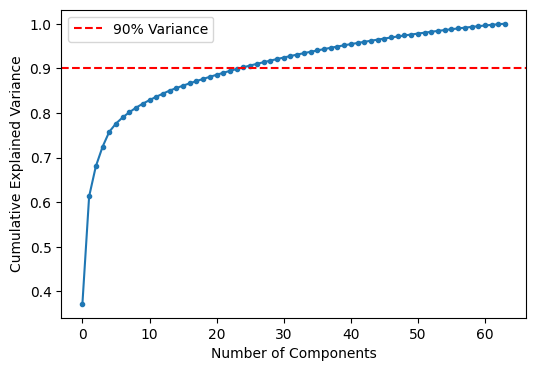

In [81]:
X = df_pivot.iloc[:,5:].values
y = df_pivot.iloc[:,2:3].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker=".")
plt.axhline(0.90, c="r", linestyle="--", label="90% Variance")
plt.legend(fontsize=6)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()

In [19]:
class_counts = df_pivot['subject_group'].value_counts(normalize=True)
print(class_counts)

subject_group
a    0.634465
c    0.365535
Name: proportion, dtype: float64


In [3]:
def scale():
    X = df_pivot.iloc[:,5:].values
    y = df_pivot.iloc[:,2:3].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y
def pca(X_scaled):
    pca = PCA(n_components=25)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca
def experiment(model, X, y):
    skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    y_pred = cross_val_predict(model, X, y, cv=skf, n_jobs=-1)
    report = classification_report(y, y_pred)
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    return (y_pred,report,scores)
def score(scores):
    error_range = (np.mean(scores) - np.min(scores), np.max(scores) - np.mean(scores))
    return (f"average acc: {np.mean(scores):.4f} /// lowest acc: {np.min(scores):.4f} /// highest acc: {np.max(scores):.4f} /// error margin: {error_range[0]:.4f}, {error_range[1]:.4f}")
def confidence_interval(scores):
    conf_int=st.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores))
    return (f"confidence interval: {round(conf_int[0], 4)}, {round(conf_int[1], 4)}")
def label_encoding(y):
    y=LabelEncoder().fit_transform(y.ravel())
    return y

### Logistic Regression

In [5]:
X_scaled, y = scale()
X_pca = pca(X_scaled)
model = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1)
y_pred_log, log_report, log_score = experiment(model,X_pca,y)
log_scores = score(log_score)
conf_interval = confidence_interval(log_score)
print(f"{log_report}\n{log_scores}\n{conf_interval}")

              precision    recall  f1-score   support

           a       0.67      0.56      0.61   1780480
           c       0.41      0.53      0.46   1025792

    accuracy                           0.55   2806272
   macro avg       0.54      0.55      0.54   2806272
weighted avg       0.58      0.55      0.56   2806272

average acc: 0.5508 /// lowest acc: 0.5493 /// highest acc: 0.5521 /// error margin: 0.0015, 0.0013
confidence interval: 0.5501, 0.5514


### XGBoost(Extreme Gradient Boosting)

In [6]:
X_scaled, y = scale()
X_pca = pca(X_scaled)
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)
y_pred_xgb, xgb_report, xgb_score = experiment(model,X_pca,label_encoding(y))
xgb_scores = score(xgb_score)
conf_interval = confidence_interval(xgb_score)
print(f"{xgb_report}\n{xgb_scores}\n{conf_interval}")

              precision    recall  f1-score   support

           0       0.75      0.89      0.81   1780480
           1       0.72      0.48      0.57   1025792

    accuracy                           0.74   2806272
   macro avg       0.73      0.69      0.69   2806272
weighted avg       0.74      0.74      0.73   2806272

average acc: 0.7408 /// lowest acc: 0.7393 /// highest acc: 0.7428 /// error margin: 0.0014, 0.0020
confidence interval: 0.7399, 0.7416


#### XGBoost(Extreme Gradient Boosting) [No PCA]

In [7]:
X_scaled, y = scale()
#X_pca = pca(X_scaled)
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)
y_pred_xgb, xgb_report, xgb_score = experiment(model,X_scaled,label_encoding(y))
xgb_scores = score(xgb_score)
conf_interval = confidence_interval(xgb_score)
print(f"{xgb_report}\n{xgb_scores}\n{conf_interval}")

              precision    recall  f1-score   support

           0       0.75      0.91      0.83   1780480
           1       0.76      0.49      0.59   1025792

    accuracy                           0.76   2806272
   macro avg       0.76      0.70      0.71   2806272
weighted avg       0.76      0.76      0.74   2806272

average acc: 0.7551 /// lowest acc: 0.7532 /// highest acc: 0.7572 /// error margin: 0.0019, 0.0021
confidence interval: 0.7541, 0.7561


#### XGBoost(Extreme Gradient Boosting) [Matching Condition y Filtered]

In [9]:
X_scaled, y = scale()
y = df_pivot.iloc[:,4:5].values
X_pca = pca(X_scaled)
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1)
y_pred_xgb, xgb_report, xgb_score = experiment(model,X_pca,label_encoding(y))
xgb_scores = score(xgb_score)
conf_interval = confidence_interval(xgb_score)
print(f"{xgb_report}\n{xgb_scores}\n{conf_interval}")

              precision    recall  f1-score   support

           0       0.58      0.92      0.71   1402112
           1       0.53      0.25      0.34    705792
           2       0.58      0.20      0.30    698368

    accuracy                           0.57   2806272
   macro avg       0.56      0.46      0.45   2806272
weighted avg       0.57      0.57      0.51   2806272

average acc: 0.5709 /// lowest acc: 0.5698 /// highest acc: 0.5721 /// error margin: 0.0011, 0.0012
confidence interval: 0.5705, 0.5713


### KNN(K-nearest neighbors)

In [49]:
X_scaled, y = scale()
X_pca = pca(X_scaled)
model = KNeighborsClassifier(n_neighbors=5)
y_pred_knn, knn_report, knn_score = experiment(model,X_pca,y)
knn_scores = score(knn_score)
conf_interval = confidence_interval(knn_score)
print(f"{knn_report}\n{knn_scores}\n{conf_interval}")

              precision    recall  f1-score   support

           a       0.88      0.94      0.91   1424335
           c       0.88      0.77      0.82    820682

    accuracy                           0.88   2245017
   macro avg       0.88      0.86      0.86   2245017
weighted avg       0.88      0.88      0.88   2245017



### Decision Tree Classifier

In [ ]:
X_scaled, y = scale()
X_pca = pca(X_scaled)
model = DecisionTreeClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
y_pred_dtc, dtc_report, dtc_score = experiment(model,X_pca,y)
dtc_scores = score(dtc_score)
conf_interval = confidence_interval(dtc_score)
print(f"{dtc_report}\n{dtc_scores}\n{conf_interval}")

In [12]:
mean_val = df_pivot.iloc[:,5:].mean()
std_dev_val = df_pivot.iloc[:,5:].std()

stats = pd.DataFrame({'Mean': mean_val, 'Standard Deviation': std_dev_val})
stats

,Mean,Standard Deviation
AF1,-1.031375,11.098754
AF2,-0.972299,10.372105
AF7,-0.828970,16.959607
AF8,-0.436477,16.367517
AFZ,-1.047624,10.642997
...,...,...
TP7,-1.634966,9.788748
TP8,-1.612973,10.021239
X,-0.431272,25.966520
Y,-2.513808,14.351777


### LDA (Latent Dirichlet Allocation)

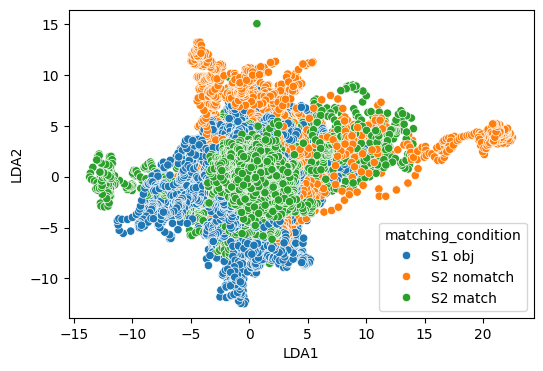

In [40]:
X = df_pivot.iloc[:,5:].values #features(voltages)
y = df_pivot.iloc[:,4:5].values #classes/labels(matching_condition)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.ravel())

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y_encoded)

lda_df = pd.DataFrame(X_lda, columns=['LDA1', 'LDA2'])
lda_df['matching_condition'] = y_encoded

matching_conditions = {0: 'S1 obj', 1: 'S2 match', 2: 'S2 nomatch'}
lda_df['matching_condition'] = lda_df['matching_condition'].map(matching_conditions)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=lda_df, x="LDA1", y="LDA2", hue="matching_condition")
plt.show()

In [38]:
y_original = label_encoder.inverse_transform(y_encoded)
y_comparison_df = pd.DataFrame({'Encoded': y_encoded,'Original': y_original})
y_comparison_unique_df = y_comparison_df.drop_duplicates()
y_comparison_unique_df

,Encoded,Original
0,0,S1 obj
22272,2,S2 nomatch
56064,1,S2 match


### Mean&Standard Deviation

In [47]:
voltages = df_pivot.columns[5:]
mean_std_df = (
    df_pivot.groupby(['subject', 'matching_condition'])[voltages]
    .agg(['mean', 'std'])
    .reset_index()
)
mean_std_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in mean_std_df.columns]

mean_df = mean_std_df[[col for col in mean_std_df.columns if '_mean' in col or col in ['subject', 'matching_condition']]]
std_df = mean_std_df[[col for col in mean_std_df.columns if '_std' in col or col in ['subject', 'matching_condition']]]

mean_df.iloc[:, 2:] = mean_df.iloc[:, 2:].round(3)
std_df.iloc[:, 2:] = std_df.iloc[:, 2:].round(3)
mean_df #122 subjects x 3 matching conditions = 366 rows

,subject,matching_condition,AF1_mean,AF2_mean,AF7_mean,AF8_mean,AFZ_mean,C1_mean,C2_mean,C3_mean,...,PO8_mean,POZ_mean,PZ_mean,T7_mean,T8_mean,TP7_mean,TP8_mean,X_mean,Y_mean,nd_mean
0,co2a0000364,S1 obj,0.882,0.863,1.523,1.239,0.924,-0.131,0.129,-0.470,...,-4.056,-2.575,-0.732,-1.926,-1.869,-2.889,-2.976,5.213,-0.426,2.747
1,co2a0000364,S2 match,-0.272,-0.416,-1.588,-1.708,0.346,-0.237,-0.385,-1.823,...,-7.073,-4.625,-2.775,-5.231,-5.403,-6.286,-6.603,-0.696,-6.377,-0.295
2,co2a0000364,S2 nomatch,1.569,1.593,0.170,0.858,1.747,-0.970,0.276,-2.309,...,-8.356,-5.619,-3.087,-5.314,-4.119,-6.521,-6.333,2.148,-4.704,1.645
3,co2a0000365,S1 obj,0.650,0.052,2.293,-0.509,0.515,0.134,-0.537,0.233,...,-2.819,-1.517,-0.432,-0.879,-0.413,-0.948,-3.014,1.362,1.496,1.566
4,co2a0000365,S2 match,-1.632,-1.276,-1.743,-2.079,-1.991,-0.581,0.280,-1.345,...,-7.326,-2.609,-0.777,-3.484,-3.965,-5.211,-6.486,-1.333,-5.042,-0.683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,co3a0000461,S2 match,-3.357,-0.664,1.131,0.785,2.506,0.893,0.554,1.881,...,-1.808,-0.049,-1.814,-1.798,1.597,-2.155,-2.884,1.820,-3.343,-3.165
362,co3a0000461,S2 nomatch,1.682,1.089,0.955,3.839,1.206,-0.657,1.108,-1.675,...,-0.223,1.674,-0.632,-0.361,0.639,-2.449,0.261,4.934,-1.152,-1.116
363,co3c0000402,S1 obj,0.170,0.549,0.873,2.201,0.331,0.361,0.216,0.282,...,-3.881,-1.693,0.023,0.249,0.050,0.237,-1.108,5.792,-0.169,-0.142
364,co3c0000402,S2 match,-2.632,-1.926,-4.267,-3.161,-1.878,-0.889,0.449,-2.205,...,-5.641,-3.557,-1.150,-5.905,-4.248,-5.583,-4.602,-7.106,-10.158,-10.183


In [48]:
std_df

,subject,matching_condition,AF1_std,AF2_std,AF7_std,AF8_std,AFZ_std,C1_std,C2_std,C3_std,...,PO8_std,POZ_std,PZ_std,T7_std,T8_std,TP7_std,TP8_std,X_std,Y_std,nd_std
0,co2a0000364,S1 obj,12.879,11.103,18.156,16.055,11.228,2.650,2.103,5.833,...,9.222,6.647,4.640,6.575,8.819,7.815,6.678,34.727,8.141,21.666
1,co2a0000364,S2 match,9.943,9.078,13.477,13.593,8.804,2.133,1.899,4.714,...,9.109,5.433,3.728,6.349,8.434,7.163,6.497,26.098,7.986,15.941
2,co2a0000364,S2 nomatch,8.835,8.006,12.429,12.763,7.878,2.189,1.858,4.754,...,9.921,6.167,4.095,6.397,8.357,7.496,6.892,24.244,7.414,14.551
3,co2a0000365,S1 obj,8.478,8.273,12.603,12.289,7.643,2.094,2.582,3.712,...,8.913,6.373,5.029,7.622,8.159,7.021,16.241,20.299,9.847,16.279
4,co2a0000365,S2 match,10.342,9.600,15.905,14.228,9.130,1.970,3.095,3.283,...,10.489,7.013,5.339,11.166,9.292,7.799,25.895,23.287,9.733,22.992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,co3a0000461,S2 match,11.802,8.291,8.620,8.994,12.249,5.706,11.117,10.819,...,9.064,8.522,8.978,8.313,9.398,9.814,16.888,18.718,16.271,15.557
362,co3a0000461,S2 nomatch,12.198,10.931,11.639,11.672,12.190,7.219,12.534,9.401,...,12.397,12.518,8.393,8.732,8.956,10.029,15.264,33.059,20.740,19.848
363,co3c0000402,S1 obj,7.058,6.798,8.751,9.005,6.344,1.966,2.070,3.197,...,8.183,6.400,5.075,6.713,6.183,6.899,6.346,24.600,10.724,10.765
364,co3c0000402,S2 match,7.773,6.912,9.483,8.944,6.770,2.301,1.817,3.690,...,8.374,6.645,6.477,6.728,6.259,6.901,6.320,27.346,11.266,11.305


### Random Forest

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1)

rskf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

y_pred = cross_val_predict(model, X_train_pca, y_train, cv=rskf, n_jobs=-1)
print(classification_report(y_train, y_pred))

rfc_scores = cross_val_score(model, X_train_pca, y_train, cv=rskf, scoring='accuracy', n_jobs=-1)

              precision    recall  f1-score   support

           a       0.76      0.72      0.74   1424335
           c       0.55      0.60      0.58    820682

    accuracy                           0.67   2245017
   macro avg       0.65      0.66      0.66   2245017
weighted avg       0.68      0.67      0.68   2245017



### Linear SVM Classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.ravel())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = SVC(kernel='linear', class_weight='balanced', random_state=42)

rskf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

y_pred = cross_val_predict(model, X_train_pca, y_train_encoded, cv=rskf, n_jobs=-1)
print(classification_report(y_train_encoded, y_pred))

svc_scores = cross_val_score(model, X_train_pca, y_train_encoded, cv=rskf, scoring='accuracy', n_jobs=-1)